<a href="https://colab.research.google.com/github/JeremiahKamama/Spacy-Analysis/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [146]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import spacy
import string



from spacy.lang.en import English
from spacy.tokens import Doc
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.tokenizer import Tokenizer


from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split

from wordcloud import WordCloud

#LinearSVC,Logistic Regression,RandomForest,DecisionTree,KNeighborsClassifier



In [147]:
nlp = spacy.load("en_core_web_sm")

In [148]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [149]:
imdb = pd.read_csv('/content/drive/MyDrive/data/IMDB.csv')

imdb.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [150]:
imdb.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [151]:
imdb.sentiment.replace("positive", 1 , inplace= True)
imdb.sentiment.replace("negative", 0, inplace= True)
imdb.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


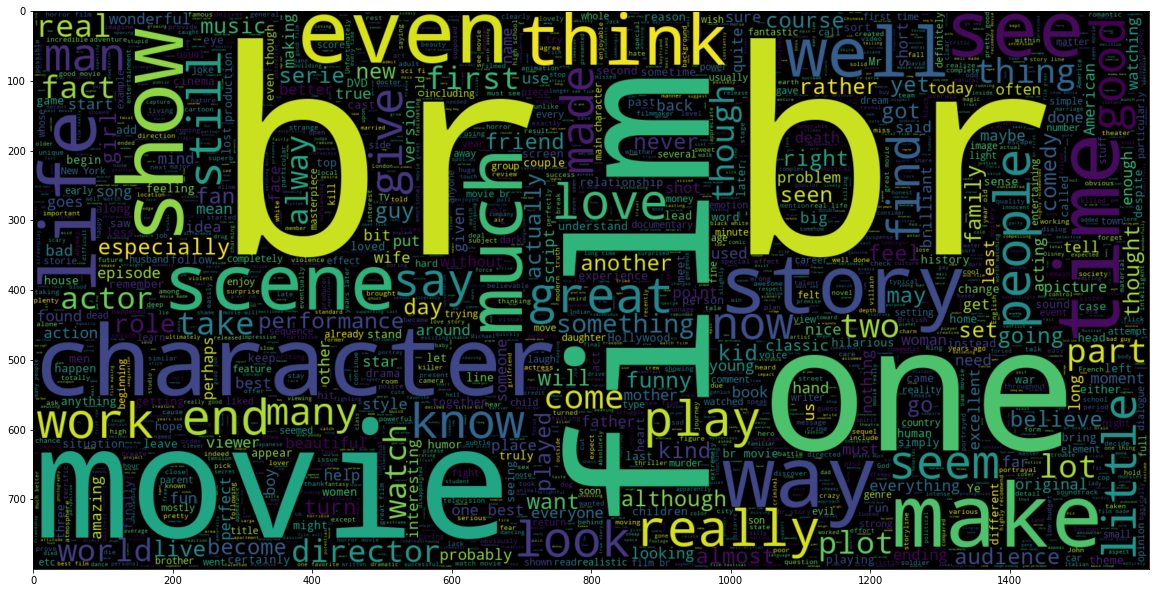

In [152]:
plt.figure(figsize = (20,20))
cloud = WordCloud(max_words= 2000, width= 1600,height= 800).generate("".join(imdb[imdb.sentiment == 1].review))
plt.imshow(cloud, interpolation='bilinear')

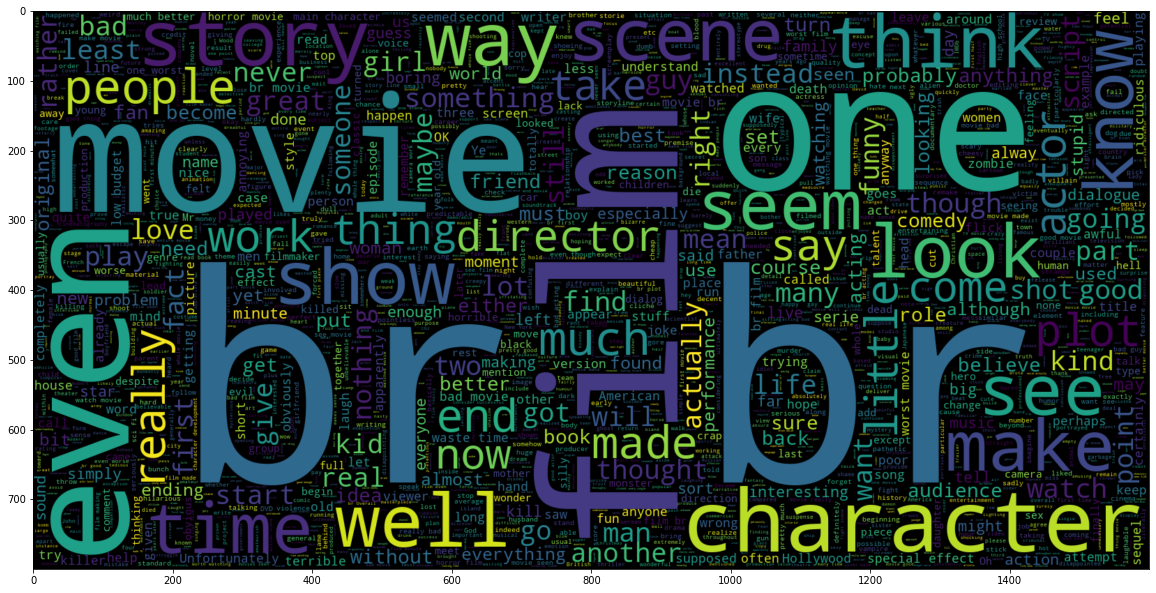

In [153]:
plt.figure(figsize = (20,20))
cloud = WordCloud(max_words= 2000, width= 1600,height= 800).generate("".join(imdb[imdb.sentiment == 0].review))
plt.imshow(cloud, interpolation='bilinear')

In [154]:
#checking missing data
miss_val = imdb.isnull().sum()

miss_val[0:10]

review       0
sentiment    0
dtype: int64

In [155]:
from spacy.lang.en.stop_words import STOP_WORDS
stopwords = list(STOP_WORDS)


In [156]:
def clean_data(sentence):
  doc = nlp(sentence)
  tokens = []
  for token in doc:
    if token.lemma_ != '-PRON-':
      temp = token.lemma_.lower().strip()
    else:
      temp = token.lower_
    tokens.append(temp)
  clean_tokens = []
  for token in tokens:
    if token not in punct and token not in stopwords:
      clean_tokens.append(token)
  return clean_tokens


In [157]:
X = imdb['review']
y = imdb['sentiment']

X_train,X_test, y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)



In [158]:
punct = string.punctuation
print(punct)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [159]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
import xgboost as xgb

#learning_rate=0.1, max_depth=7,n_estimators=80,use_label_encoder=False,eval_metric='auc'
tfidf = TfidfVectorizer(tokenizer = clean_data)


steps = [('tfidf',tfidf), ('classifier', xgb.XGBClassifier(random_state=1,learning_rate=0.1))]

pipe = Pipeline(steps)


 

In [160]:
# pipe.fit(X_train, y_train)

In [161]:
#y_pred = pipe.predict(X_test)

In [162]:
from sklearn.metrics import confusion_matrix

#print(confusion_matrix(y_test,y_pred))

In [163]:
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

pipe = Pipeline([('bow',CountVectorizer()),('tfid',TfidfTransformer()),('model', MultinomialNB())])


In [164]:

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

print(accuracy_score(y_test,y_pred))



0.8635


In [165]:
print(confusion_matrix(y_test,y_pred))

[[4405  556]
 [ 809 4230]]


In [166]:
!pip install transformers
!pip install torchvision

In [167]:
from typing import Mapping,List

import transformers
from torchtext.legacy import data
from transformers import DistilBertTokenizer, DistilBertConfig,DistilBertModel


import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F 




In [168]:
model_name = 'distilbert-base-uncased'
NUM_EPOCHS = 3
LEARNING_RATE = 2
MAX_LENGTH = 512
TRUNCATION = True
BATCH_SIZE = 32
WEIGHT_DECAY = 1e-3
ACCUMUCALTION_STEPS =3
SEED = 42
FP_16 = dict(opt_level="01")
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased", truncation= True)



In [169]:
class IMDB(Dataset):
    def __init__(self, review, sentiment, max_len,truncation: str = True,):
        self.tokenizer = tokenizer
        self.review = review
        self.sentiment = sentiment
        self.max_len = MAX_LENGTH

    def __len__(self):
        return len(self.review)

    def __getitem__(self, index):
        text = str(self.review[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.sentiment[index], dtype=torch.float)
        }

In [170]:
df_train, df_test = train_test_split(
            imdb,
            test_size=0.2,
            random_state=42,
            stratify = imdb.sentiment.values
        )

print(df_train.shape, df_test.shape)

(40000, 2) (10000, 2)


In [171]:
train_dataset = IMDB(review=df_train['review'].values.tolist(),sentiment=df_train['sentiment'].values,max_len=MAX_LENGTH, truncation= True)

test_dataset = IMDB(review=df_test['review'].values.tolist(),sentiment=df_test['sentiment'].values,max_len=MAX_LENGTH, truncation= True)


In [172]:
#train_loader = {"train":(DataLoader(dataset= df_train,batch_size=BATCH_SIZE,shuffle=True, num_workers=2,pin_memory=True)}
#test_loader = {"test":(DataLoader(dataset= df_test,batch_size=BATCH_SIZE,num_workers=2, pin_memory=True)}

In [173]:
print(test_dataset.review[25])
test_dataset[25]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


This is not a GREAT movie as tho the cast (especially the kids) admirably help to carry along this very sad yet contrived plot it is filled with cliché upon cliché. Poor family in 50's mid America, dying mother, alcoholic father, 10 children (1 of whom has epilepsy) and an awful decision to be made. Its very easy to watch and some of the kids performances are moving without being sickly or naff. And little Frank and Warrnen steal the show for me with the last scene leaving me bawling no matter how many times I see it. A great rainy afternoon movie i recommend to all. Only those with the hardest of hearts could fail to be moved by it. Not on a par to Sophies Choice but a good TV movie equivalent!!!


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


{'ids': tensor([  101,  2023,  2003,  2025,  1037,  2307,  3185,  2004, 27793,  1996,
          3459,  1006,  2926,  1996,  4268,  1007,  4748, 14503,  8231,  2393,
          2000,  4287,  2247,  2023,  2200,  6517,  2664,  9530, 18886,  7178,
          5436,  2009,  2003,  3561,  2007, 18856, 17322,  2588, 18856, 17322,
          1012,  3532,  2155,  1999,  2753,  1005,  1055,  3054,  2637,  1010,
          5996,  2388,  1010, 14813,  2269,  1010,  2184,  2336,  1006,  1015,
          1997,  3183,  2038,  4958,  9463, 18075,  1007,  1998,  2019,  9643,
          3247,  2000,  2022,  2081,  1012,  2049,  2200,  3733,  2000,  3422,
          1998,  2070,  1997,  1996,  4268,  4616,  2024,  3048,  2302,  2108,
          5305,  2135,  2030,  6583,  4246,  1012,  1998,  2210,  3581,  1998,
          2162, 12119,  2078,  8954,  1996,  2265,  2005,  2033,  2007,  1996,
          2197,  3496,  2975,  2033,  8670, 13668,  2075,  2053,  3043,  2129,
          2116,  2335,  1045,  2156,  2009,  

In [174]:

eos_token = tokenizer.sep_token
unk_token = tokenizer.unk_token
pad_token = tokenizer.pad_token
init_token = tokenizer.cls_token


print(init_token, eos_token, unk_token, pad_token)

[CLS] [SEP] [UNK] [PAD]


In [175]:
init_token_idx = tokenizer.convert_tokens_to_ids(init_token)
eos_token_idx = tokenizer.convert_tokens_to_ids(eos_token)
unk_token_idx = tokenizer.convert_tokens_to_ids(unk_token)
pad_token_idx = tokenizer.convert_tokens_to_ids(pad_token)

In [176]:
max_input_length = 512

In [177]:

def tokenize_cut(sentence):
    tokens = tokenizer.tokenize(sentence) 
    tokens = tokens[:max_input_length-2]
    return tokens

REVIEW = data.Field(batch_first = True,
                  use_vocab = False,
                  tokenize = tokenize_cut,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = init_token_idx,
                  eos_token = eos_token_idx,
                  pad_token = pad_token_idx,
                  unk_token = unk_token_idx)

SENTIMENT = data.LabelField(dtype = torch.float)

In [178]:
#tokens = tokenizer.convert_ids_to_tokens(vars(train_loader[6])['text'])

#print(tokens)

In [179]:
from torchtext.legacy import data

train_iterator, test_iterator = data.BucketIterator.splits(
    (train_dataset,test_dataset),
    sort_key = lambda x: len(x[review]),
    batch_size = 32,
    #sort= False,
    #sort_within_batch = True
    #device = device
    )

In [180]:
class DistilBert(nn.Module):

    def __init__(self, pretrained_model_name: str = 'distilbert-base-uncased', num_classes: int = 2):

        super(DistilBert,self).__init__()

        config = DistilBertConfig.from_pretrained("distilbert-base-uncased")

        self.distilbert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = nn.Linear(config.dim, config.dim)
        self.classifier = nn.Linear(config.dim, num_classes)
        self.dropout = nn.Dropout(config.seq_classif_dropout)

    def forward(self, input_ids, attention_mask):

        distilbert_output = self.distilbert(input_ids=input_ids,
                                            attention_mask=attention_mask)
        hidden_state = distilbert_output[0]  # [BATCH_SIZE=32, MAX_SEQ_LENGTH = 512, DIM = 768]
        pooled_output = hidden_state[:, 0]  # [32, 768]
        pooled_output = self.pre_classifier(pooled_output)  # [32, 768]
        pooled_output = F.relu(pooled_output)  # [32, 768]
        pooled_output = self.dropout(pooled_output)  # [32, 768]
        logits = self.classifier(pooled_output)  # [32, 2]

        return logits

In [181]:
model = DistilBert()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [182]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss()

In [183]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [184]:
def train(model, iterator, optimizer, criterion):
    
    model.train()
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.sentiment)
        
        acc = binary_accuracy(predictions, batch.sentiment)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [185]:
def evaluate(model, iterator, criterion):
    
    #epoch_loss = 0
    #epoch_acc = 0
    
    #model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.sentiment)
            
            acc = binary_accuracy(predictions, batch.sentiment)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [186]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [187]:
for epoch in range(NUM_EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer,criterion)
    test_loss, test_acc = evaluate(model, test_iterator, criterion)
        
    end_time = time.time()
        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


AttributeError: ignored

In [ ]:
def prediction(model, sentence: str, max_len: int = 512, device = 'cpu'):
    x_encoded = tokenizer.encode_plus(sentence, add_special_tokens=True, pad_to_max_length=True, max_length=max_len, return_tensors="pt",).to(device)
    logits = model(x_encoded['input_ids'], x_encoded['attention_mask'])
    probabilities = F.softmax(logits.detach(), dim=1)
    output = probabilities.max(axis=1)
    print(sentence)
    print(f"Sentiment: {['Negative' if output.indices[0] == 0 else 'Positive'][0]}") 
    #Probability: {output.values[0]:.4f}")


In [ ]:
prediction(model, df_test['review'].values[10])


In [ ]:
def trainModel(model, train_iterator,test_iterator, criterion, optimizer, verbose=True):
    """Train sentiment classifier
  """
    # structure to store progress of the model at each epoch
    #history = defaultdict(list)
    
    # move the model to the gpu
    model = model.to(device= 'cpu')

    for ep in range(NUM_EPOCHS):
        total_loss = 0
        correct = 0
        # set model to train mode so dropout and batch normalisation layers work as expected
        model.train()

        for batch in train_iterator:
            # get inputs for batch
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # calculate output + loss
            model.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs.squeeze(), targets.long())

            # take gradient step
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            #scheduler.step()

            # update losses
            _, pred = torch.max(outputs, dim=1)
            correct += (pred == targets).sum().item()
            total_loss += loss.item()*len(targets)

        #after each epoch, collect statistics
        history['train_acc'].append(100*correct/len(X_train))
        history['train_loss'].append(total_loss/len(X_train))

        # statistics about the validation set
        val_acc, val_loss = evalModel(model, valDataLoader, loss_fn, len(X_val))
        history['val_acc'].append(val_acc)
        history['vall_loss'].append(val_loss)

        #if validation improved, save new best model
        if history['val_acc'][-1] == max(history['val_acc']):
            print ("=> Saving a new best at epoch:", ep)
            torch.save(model.state_dict(), 'best_model_state.bin')
        
        if verbose:
            print('Epoch {}/{}'.format(ep+1, EPOCHS))
            print('-' * 10)
            print('Train loss {} accuracy {}'.format(history['train_loss'][-1], history['train_acc'][-1]))
            print('Val loss {} accuracy {}'.format(val_loss, val_acc))

    #clean up
    model = model.to(torch.device("cpu"))
    del input_ids, attention_mask, targets, outputs, _, pred

    return model, history

In [ ]:

def evalModel(model, iterator, criterion, N):
    """Evaluate loss and accuracy of model on data_loader"""
    # set model to evaluation mode
    model = model.eval()
    total_loss = 0
    correct = 0

    with torch.no_grad():
        for batch in iterator:
            # get inputs and target 
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # pass through model + make prediction
            outputs = model(input_ids, attention_mask)
            _, pred = torch.max(outputs, dim=1)

            # update counters
            loss = criterion(outputs, targets)
            correct += (pred == targets).sum().item()
            total_loss += loss.item()*len(targets)

    # normalise
    return 100*correct/N, total_loss/N

In [ ]:
best_model, histories = trainModel(model, train_iterator, test_iterator, criterion, optimizer, verbose=True)

In [ ]:

test_acc, test_loss = evalModel(best_model.to(device), test_data_loader, loss_fn, len(y_test))

In [ ]:

print(test_acc, test_loss)